## Customer Reviews Challenge ##

The follow exercise is for the customer reviews challenge.  I used a naive bayes model attempt to predict whether a Yelp review was postive or negative.  This model was then tested on a Amazon reviews dataset.

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
import scipy.stats as stats

In [8]:
# IMPORTING YELP DATA
df = pd.read_csv("C:\\Users\\Chris\\Documents\\Python Scripts\\Thinkful File Examples\\Sentiment\\sentiment labelled sentences\\yelp_labelled.txt", delimiter='\t', header=None)
df.columns=['comment', 'score']

## Data Cleaning ##

The first step was to clean the data.  Below, I used a function that made the string lowercase and removed all symbols and blanks.

Also above is my global list of some frequently used conjunctions.

In [9]:
conj = ['the','and','i','a','to','this','in','of','it','was','we','is','my', 'im', 'if', 'on', 'be', 'our', 'you']

def dataclean(data):
    # Make everything lower case
    data = data.str.lower()

    # Remove non-text characters
    data = data.str.replace(r'\.|\!|\?|\'|,|-|\(|\)', "",)

    # Fill in blank reviews with '' rather than Null (which would give us errors)
    data = data
    return data

df['comment'] = dataclean(df['comment'])
    

## Feature Engineering ##

In the next step, I wanted to find out which words were prevalent in positive comments and which were prevalent in negative comments.

The below code takes each comment and splits it down to the word level.  Words are then counted to see how many occur in both positive and negative data sets.  Common conjunctions where removed.  Use cell outputs a list of the top 50 in each dataset.

In [10]:
# Postive comments Engineering Selection

positive_comments = df.loc[df['score'] == 1]
pos_wordcount = {}

# Test for most used single words
for i, row in positive_comments.iterrows():
    words = row['comment'].split()
    for x in words:
        # Remove Conjunctions
        if x in conj:
            break
        # else add to wordcount dict for counting
        elif x not in pos_wordcount:
            pos_wordcount[x] = 1
        else:
            pos_wordcount[x] += 1
            
# View the Top 50 words
pd.Series(pos_wordcount).sort_values(ascending=False)[0:50]

great         29
service       20
good          19
food          17
they          14
very          11
for            9
back           8
are            8
their          7
have           7
best           6
also           6
place          6
so             6
all            6
definitely     5
as             5
here           5
nice           5
its            5
will           5
were           5
everything     4
spicy          4
delicious      4
both           4
really         4
an             4
always         4
just           4
when           4
awesome        4
selection      4
by             4
he             4
only           4
had            4
stars          3
steak          3
bread          3
time           3
spot           3
pretty         3
say            3
5              3
that           3
now            3
beer           3
fantastic      3
dtype: int64

In [11]:
# Negative comments Engineering Selection

negative_comments = df.loc[df['score'] == 0]
neg_wordcount = {}

for i, row in negative_comments.iterrows():
    words = row['comment'].split()
    for x in words:
        # Conjunction words
        if x in conj:
            break
        # else add to wordcount dict
        elif x not in neg_wordcount:
            neg_wordcount[x] = 1
        else:
            neg_wordcount[x] += 1

pd.Series(neg_wordcount).sort_values(ascending=False)[0:50]

not              21
service          12
for              12
very             11
never            11
there             9
food              8
go                8
ive               8
your              8
here              8
they              7
bad               7
but               7
at                7
back              7
been              7
dont              7
after             6
will              6
what              6
ordered           5
as                5
are               5
from              5
ever              5
an                5
like              5
all               5
so                5
when              4
no                4
overall           4
had               4
time              4
waste             4
have              4
worst             4
its               4
unfortunately     3
he                3
even              3
came              3
more              3
again             3
money             3
total             3
that              3
by                3
do                3


Below is an attempt to look at the similarities between the two word dicts and if there are words that are common in both dicts.



In [19]:
# Discover whether a word in the positive wordcount dict is in negative wordcount dict
disc_df = pd.DataFrame(columns=['words', 'match', 'score'])
disc_df['words'] = list(pos_wordcount.keys())
for i, row in disc_df.iterrows():
    try:
        x = row['words'] #If True than 'match' = True - Indicates if words are in BOTH dicts
        row['match'] = True
        #Score is finding if there are more matched words in Positive Comments vs Negative Comments  
        row['score'] = pos_wordcount[x] - neg_wordcount[x]
    except:
        row['match'] = False
        pass

disc_df.loc[disc_df['match'] == True]
#disc_df.sort_values('score', ascending=False).head(10)
#disc_df.sort_values('score', ascending=True).head(10)

,words,match,score
93,not,True,-19
308,never,True,-10
17,there,True,-7
174,your,True,-6
165,ive,True,-6
280,been,True,-5
223,at,True,-5
192,but,True,-5
41,go,True,-5
27,after,True,-4


In [18]:
pos_wordcount['good']

19

Positive words like 'great', 'good', 'best', 'nice', 'delicious', 'awesome' and 'amazing' were all represented on the list and could be a good indication that this review was a positive one.

Negative words like 'never', 'bad', 'worst', 'waste' and 'unfortunately' were all represented on the list and could be a good indication that this review was a negative one.

In [24]:
positive_keywords = ['great', 'good', 'best', 'nice', 'delicious', 'awesome', 'amazing', 'beautiful', 'recommendation']
negative_keywords = ['not', 'never', 'bad', 'worst', 'waste', 'unfortunately']

def keywordcheck(keywords, df):
    for key in keywords:
        df[str(key)] = df.comment.str.contains(str(key), case=False)
    return df
    
ptest = keywordcheck(positive_keywords, df)
ptest = ptest.drop(labels=negative_keywords, axis=1)
ntest = keywordcheck(negative_keywords, df)
ntest = ntest.drop(labels=positive_keywords, axis=1)

In [22]:
ptest['score'] = (ptest['score'] == 1)
ntest['score'] = (ntest['score'] == 0)

C:\Users\Chris\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


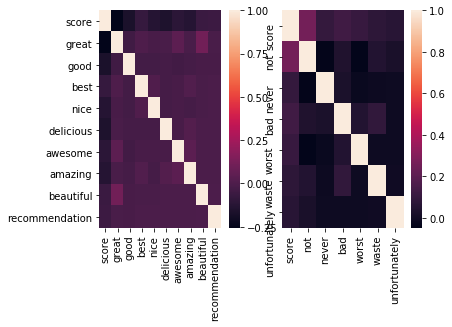

In [25]:
fig, (ax, ax2) = plt.subplots(ncols=2)
sns.heatmap(ptest.corr(), ax=ax)
sns.heatmap(ntest.corr(), ax=ax2)
fig.show()

Looking at the above heatmap - there appears to be some correlations in the positive comments with the words ‘great’ and ‘beautiful’ and ‘great’ and ‘awesome’.  But there are not any strong correlations between the ‘score’ and any other features.  In the negative heatmap, ‘not’ and ‘score’ has a strong correlation. 

Below is the naive bayes model.  Its using the Bernoulli classifier since this is a boolean output.

In [26]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB
def naivebayes(data, target):
    # Instantiate our model and store it in a new variable.
    bnb = BernoulliNB()
    # Fit our model to the data.
    bnb.fit(data, target)
    # Classify, storing the result in a new variable.
    y_pred = bnb.predict(data)
    # Display our results.
    print("Number of correctly labeled points out of a total {} points : {}".format(
        data.shape[0],
        (target == y_pred).sum()
    ))
    
    print("Number of mislabeled points out of a total {} points : {}".format(
        data.shape[0],
        (target != y_pred).sum()
    ))
    return y_pred
    
    
pos_yelp = naivebayes(ptest[positive_keywords], df['score'])
neg_yelp = naivebayes(ntest[negative_keywords], df['score'])

Number of correctly labeled points out of a total 1000 points : 690
Number of mislabeled points out of a total 1000 points : 310
Number of correctly labeled points out of a total 1000 points : 633
Number of mislabeled points out of a total 1000 points : 367


Using the model above, we came up to a 69% success rate in detecting both positive and 63% negative comments on Yelp.

In [27]:
amazon_df = pd.read_csv("C:\\Users\\Chris\\Documents\\Python Scripts\\Thinkful File Examples\\Sentiment\\sentiment labelled sentences\\amazon_cells_labelled.txt", delimiter='\t', header=None)
amazon_df.columns=['comment', 'score']

In [28]:
amazon_ptest = keywordcheck(positive_keywords, amazon_df)
amazon_ntest = keywordcheck(negative_keywords, amazon_df)

amazon_ptest['score'] = (amazon_ptest['score'] == 1)
amazon_ntest['score'] = (amazon_ntest['score'] == 0)

pos_amazon = naivebayes(ptest[positive_keywords], amazon_df['score'])
neg_amazon = naivebayes(ntest[negative_keywords], amazon_df['score'])

Number of correctly labeled points out of a total 1000 points : 521
Number of mislabeled points out of a total 1000 points : 479
Number of correctly labeled points out of a total 1000 points : 519
Number of mislabeled points out of a total 1000 points : 481


But using the Amazon reviews this model only achieves 52% success on both positive and negative reviews.